In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load Dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/ToothCavityProject/ToothCavityProject/dental_dataset', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [5]:
# Model
class CavityCNN(nn.Module):
    def __init__(self):
        super(CavityCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 30 * 30, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = CavityCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Training
train_loss_hist, val_loss_hist = [], []
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().to(device).view(-1, 1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_hist.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.float().to(device).view(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss_hist.append(val_loss / len(val_loader))
    print(f"Epoch [{epoch+1}/10] - Train Loss: {train_loss_hist[-1]:.4f} - Val Loss: {val_loss_hist[-1]:.4f}")

Epoch [1/10] - Train Loss: 0.6941 - Val Loss: 1.5040
Epoch [2/10] - Train Loss: 1.2082 - Val Loss: 0.9445
Epoch [3/10] - Train Loss: 0.7890 - Val Loss: 0.9109
Epoch [4/10] - Train Loss: 0.7467 - Val Loss: 0.7484
Epoch [5/10] - Train Loss: 0.6220 - Val Loss: 0.6719
Epoch [6/10] - Train Loss: 0.5553 - Val Loss: 0.6543
Epoch [7/10] - Train Loss: 0.5214 - Val Loss: 0.6460
Epoch [8/10] - Train Loss: 0.4870 - Val Loss: 0.6175
Epoch [9/10] - Train Loss: 0.4302 - Val Loss: 0.5882
Epoch [10/10] - Train Loss: 0.3725 - Val Loss: 0.5498


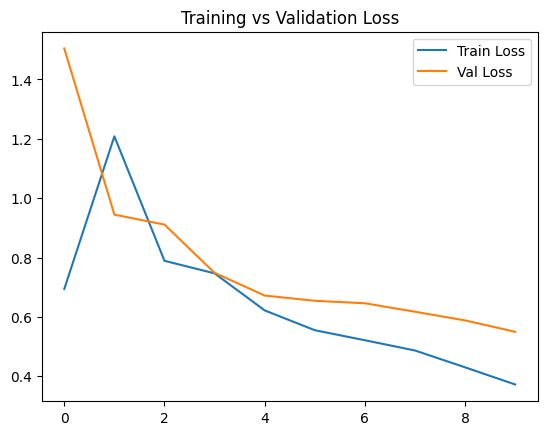

In [7]:
# Plotting
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
torch.save(model.state_dict(), 'cavity_model.pth')


In [8]:
from PIL import Image
import torchvision.transforms as transforms

In [10]:
# Load model
model = CavityCNN()
model.load_state_dict(torch.load('cavity_model.pth', map_location=torch.device('cpu')))
model.eval()

# Transform for single image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load and preprocess image
img = Image.open("/content/caries-dental-decay-dentist.jpg").convert("RGB")
img = transform(img).unsqueeze(0)  # Add batch dimension

# Predict
with torch.no_grad():
    output = model(img)
    pred = torch.round(output).item()

if pred == 1:
    print("🦷 No Cavity Detected")
else:
    print("⚠️ Cavity Detected")

⚠️ Cavity Detected
